In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.8.1].
device:[cuda:0].


In [2]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

Done.


#### Model
nn.LSTM parameters
1. input_size : The # of expected features in the input x
2. hidden_size : The # of features in the hidden state h
3. num_layers : # of recurrent layers.  
4. batch_first : True라면, input, output tensor가 (batch, seq, feature) 순으로 정렬된다. False라면, (seq, batch, feature) 순이다. 

Inputs : input, (h_0, c_0)
1. input : tensor (N=batch size, L=sequence length, H_in=input_size) if batch_first=True.
2. h_0 : tensor (D*num_layers, N, H_out= proj_size if proj_size>0 otherwise hidden_size) 
3. c_o : tensor (D*num_layers, N, H_cell=hidden_size) 


Outputs : output, (h_n, c_n)
1. output : tensor (N, L, H_out)
2. h_n : tensor(D*num_layers, N, H_out)
3. c_n : tensor(D*num_layers, N, H_cell)

if num_layers = 2
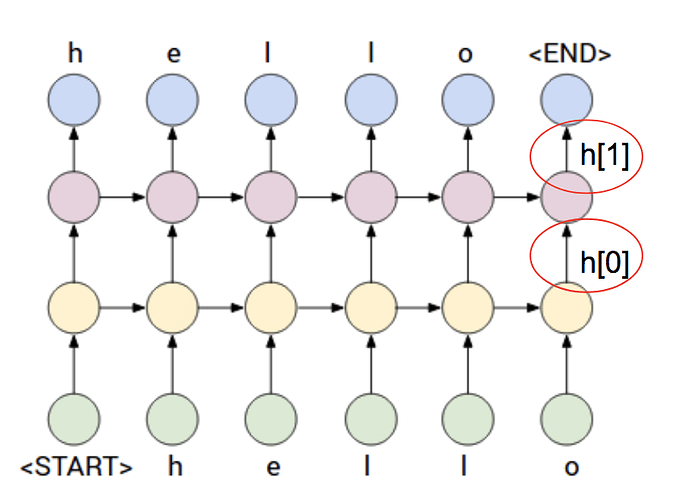

In [3]:
class RNN(nn.Module):
    def __init__(self, name='rnn', xdim=28, hdim=256, ydim=10, n_layer=3):
        super(RNN, self).__init__()
        self.name = name
        self.xdim = xdim
        self.hdim = hdim
        self.ydim = ydim
        self.n_layer = n_layer 
        
        self.rnn = nn.LSTM(input_size = self.xdim ,
                          hidden_size = self.hdim,
                          num_layers = self.n_layer,
                          batch_first = True)
        self.lin = nn.Linear(self.hdim, self.ydim)
        
    def forward(self, x):
        
        h0 = torch.zeros(self.n_layer,x.size(0), self.hdim).to(device)
        c0 = torch.zeros(self.n_layer,x.size(0), self.hdim).to(device)
        # RNN
        rnn_out, (hn, cn) = self.rnn(x, (h0, c0))
        # Linear
        out = self.lin(rnn_out[:,-1,:]).view([-1, self.ydim]) # []
        return out

R = RNN(name = 'rnn',
       xdim = 28, 
       hdim = 256,
       ydim = 10, 
       n_layer = 2).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(R.parameters(), lr=1e-3)
print("Done.")
        

Done.


reference : https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=songblue61&logNo=221853600720
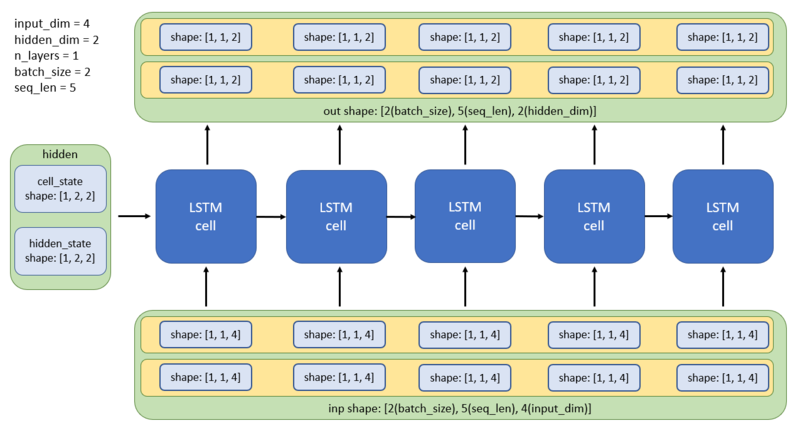

1. **Forget gate** : forget useless data
* $f_t = \sigma(W_f*[h_{t-1}, x_t] + b_f)$ 

→ prev hidden state $h_{t-1}$ 에서 잊어버릴 것 버리는 과정

2. **Input gate** : decide which data to store 
* $i_t = \sigma(W_i*[h_{t-1}, x_t] + b_i)$
* $\hat{C_t} = tanh(W_C*[h_{t-1}, x_t] + b_c)$

→ prev hidden state와 현재 input x 에서 cell state 후보군을 뽑는다. 

3. **Updata cell** 
* $C_t = f_t*C_{t-1} + i_t*\hat{C_t}$
4. **Output gate** 
* $o_t = \sigma(W_o[h_{t-1}, x_t] + b_o)$
* $h_t = o_t*tanh(C_t)$

In [4]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(2,20,28) # [N x L x Q]
x_torch = torch.from_numpy(x_numpy).float().to(device)
rnn_out,(hn,cn) = R.rnn(x_torch) # forward path

print ("rnn_out:",rnn_out.shape) # [N x L x D]
print ("Hidden State hn:",hn.shape) # [K x N x D]
print ("Cell States cn:",cn.shape) # [K x N x D]

rnn_out: torch.Size([2, 20, 256])
Hidden State hn: torch.Size([2, 2, 256])
Cell States cn: torch.Size([2, 2, 256])


In [5]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(3,10,28) # [N x L x Q]
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = R.forward(x_torch) # [N x 1 x R] where R is the output dim.
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array
print ("x_torch:\n",x_torch)
print ("y_torch:\n",y_torch)
print ("x_numpy %s"%(x_numpy.shape,))
print ("y_numpy %s"%(y_numpy.shape,))

x_torch:
 tensor([[[5.475e-01, 9.060e-01, 5.568e-01, 5.622e-01, 2.784e-02, 2.469e-01,
          6.507e-01, 8.857e-01, 5.517e-01, 6.828e-01, 4.254e-01, 8.903e-01,
          1.787e-02, 9.401e-01, 2.622e-01, 2.781e-01, 3.719e-01, 5.874e-03,
          5.852e-01, 1.567e-01, 5.169e-01, 5.498e-01, 3.010e-01, 6.065e-01,
          8.044e-01, 8.206e-01, 7.571e-01, 7.835e-01],
         [5.775e-01, 9.994e-01, 1.411e-01, 6.180e-01, 5.026e-01, 8.880e-01,
          6.522e-01, 5.723e-01, 9.499e-01, 9.245e-01, 2.943e-01, 1.553e-01,
          4.901e-01, 9.464e-01, 7.454e-01, 5.659e-01, 6.027e-01, 7.813e-01,
          4.341e-01, 6.831e-02, 5.124e-01, 7.565e-01, 2.172e-01, 6.231e-01,
          8.179e-01, 2.446e-01, 2.140e-01, 8.259e-01],
         [5.367e-01, 7.191e-01, 2.519e-01, 7.739e-01, 6.274e-01, 6.776e-01,
          7.910e-01, 8.591e-01, 8.448e-01, 6.644e-01, 7.158e-01, 1.200e-01,
          4.183e-02, 7.460e-01, 3.706e-01, 4.012e-01, 4.147e-01, 2.984e-01,
          6.225e-01, 8.598e-01, 5.928e-03, 8

In [6]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct = 0,0
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model.forward(batch_in.view(-1,28,28).to(device))
            _,y_pred = torch.max(model_pred,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode 
    return val_accr
print ("Done")

Done


In [7]:
train_accr = func_eval(R,train_iter,device)
test_accr = func_eval(R,test_iter,device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.098] test_accr:[0.097].


#### Train

In [8]:
print ("Start training.")
R.train() # to train mode 
EPOCHS,print_every = 5,1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in,batch_out in train_iter:
        # Forward path
        y_pred = R.forward(batch_in.view(-1,28,28).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad() # reset gradient 
        loss_out.backward() # backpropagate
        optm.step() # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(R,train_iter,device)
        test_accr = func_eval(R,test_iter,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")

Start training.
epoch:[0] loss:[0.653] train_accr:[0.936] test_accr:[0.939].
epoch:[1] loss:[0.142] train_accr:[0.964] test_accr:[0.963].
epoch:[2] loss:[0.092] train_accr:[0.978] test_accr:[0.976].
epoch:[3] loss:[0.063] train_accr:[0.986] test_accr:[0.983].
epoch:[4] loss:[0.049] train_accr:[0.987] test_accr:[0.983].
Done


LSTM forward에서 rnn_out[:,-1,:]의 역할은?
* 마지막 sequence를 가져온다. 

In [9]:
arr = torch.Tensor(3,4,2)
arr

tensor([[[2.939e-39, 1.047e-38],
         [9.092e-39, 1.056e-38],
         [2.939e-39, 4.408e-39],
         [4.408e-39, 5.143e-39]],

        [[4.684e-39, 4.041e-39],
         [5.969e-39, 6.704e-39],
         [3.306e-39, 4.408e-39],
         [4.408e-39, 9.367e-39]],

        [[5.235e-39, 4.867e-39],
         [4.867e-39, 4.867e-39],
         [4.408e-39, 0.000e+00],
         [0.000e+00, 0.000e+00]]])

In [10]:
arr[:,-1,:]

tensor([[4.408e-39, 5.143e-39],
        [4.408e-39, 9.367e-39],
        [0.000e+00, 0.000e+00]])

#### Test

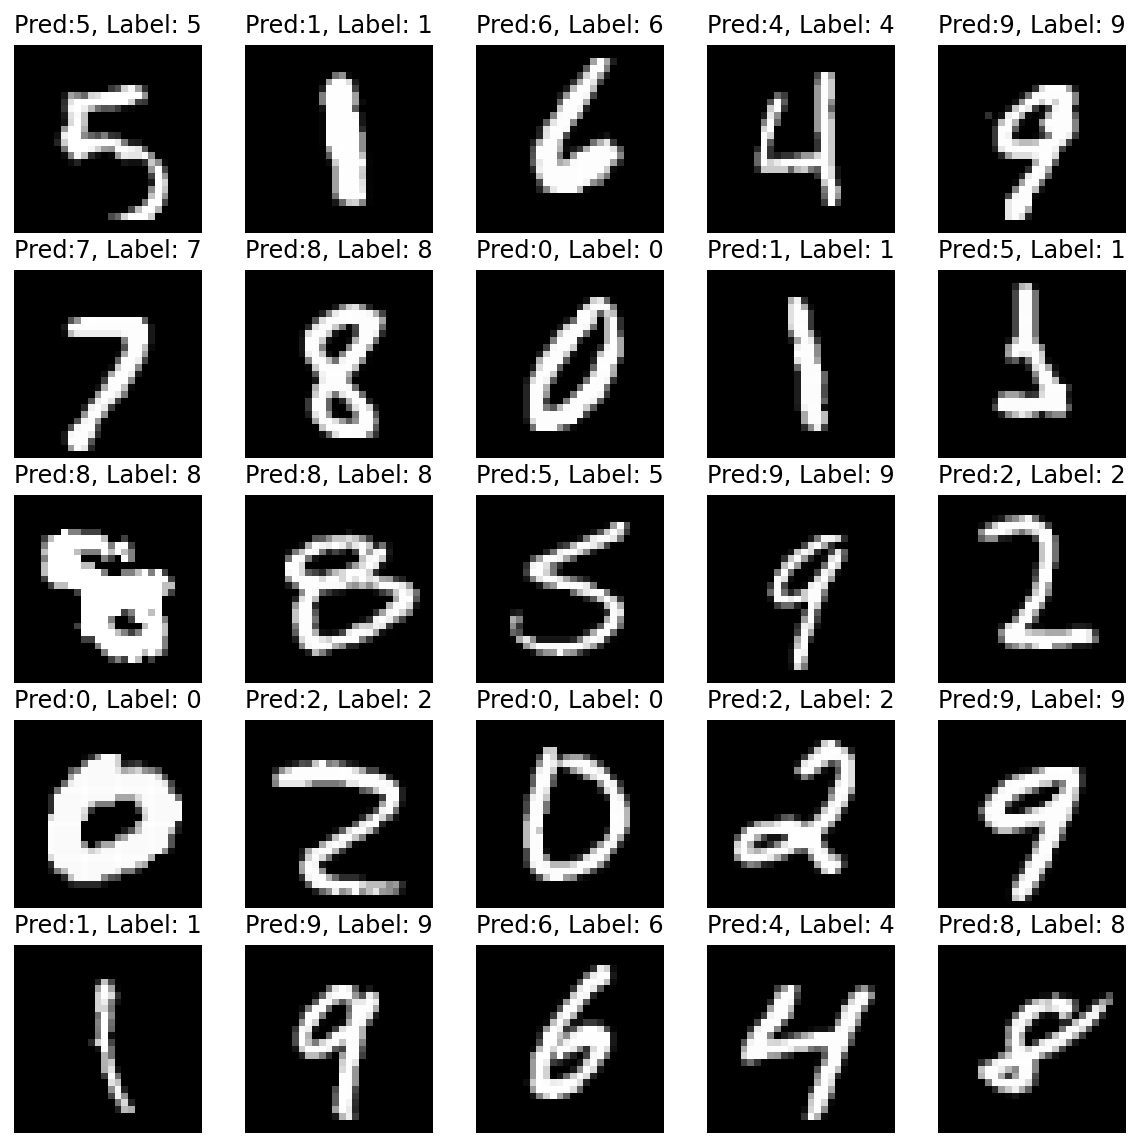

Done


In [13]:
n_sample = 25
test_iter2 = torch.utils.data.DataLoader(mnist_test, batch_size = n_sample, shuffle=True, num_workers=1)

with torch.no_grad():
    R.eval()
    for batch_in, batch_out in test_iter2:
        y_trgt = batch_out.to(device)
        model_pred = R.forward(batch_in.view(-1, 28, 28).to(device))
        _, y_pred = torch.max(model_pred, 1)
        break
    
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5,5,idx+1)
    plt.imshow(batch_in[idx,0,:,:], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label: %d"%(y_pred[idx], y_trgt[idx]))
plt.show()
print("Done")